Import Libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

Read in Dataset

In [0]:
#attribute list
col_names = ['age','workclass','fnlwgt','education','education_num','marital_status','occupation','relationship','race','sex','capital_gain','capital_loss','hours_per_week','native_country','income']

In [0]:
#reading in the training data and the data to be predicted
adult_data_train=pd.read_csv('adult.data',names=col_names)
adult_data_test= pd.read_csv('adult.test', names=col_names, skiprows=1)

EDA

In [71]:
adult_data_train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [72]:
adult_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [73]:
adult_data_train.sex.unique()

array([' Male', ' Female'], dtype=object)

In [74]:
adult_data_train.race.unique()

array([' White', ' Black', ' Asian-Pac-Islander', ' Amer-Indian-Eskimo',
       ' Other'], dtype=object)

In [76]:
adult_data_train.relationship.unique()

array([' Not-in-family', ' Husband', ' Wife', ' Own-child', ' Unmarried',
       ' Other-relative'], dtype=object)

In [75]:
adult_data_train.education.unique()

array([' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th',
       ' Some-college', ' Assoc-acdm', ' Assoc-voc', ' 7th-8th',
       ' Doctorate', ' Prof-school', ' 5th-6th', ' 10th', ' 1st-4th',
       ' Preschool', ' 12th'], dtype=object)

In [80]:
adult_data_train.workclass.unique()

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay',
       ' Never-worked'], dtype=object)

In [79]:
adult_data_train.occupation.unique()

array([' Adm-clerical', ' Exec-managerial', ' Handlers-cleaners',
       ' Prof-specialty', ' Other-service', ' Sales', ' Craft-repair',
       ' Transport-moving', ' Farming-fishing', ' Machine-op-inspct',
       ' Tech-support', ' ?', ' Protective-serv', ' Armed-Forces',
       ' Priv-house-serv'], dtype=object)

In [78]:
adult_data_train.income.unique()

array([' <=50K', ' >50K'], dtype=object)

In [81]:
adult_data_train.marital_status.unique()

array([' Never-married', ' Married-civ-spouse', ' Divorced',
       ' Married-spouse-absent', ' Separated', ' Married-AF-spouse',
       ' Widowed'], dtype=object)

In [77]:
adult_data_train.native_country.unique()

array([' United-States', ' Cuba', ' Jamaica', ' India', ' ?', ' Mexico',
       ' South', ' Puerto-Rico', ' Honduras', ' England', ' Canada',
       ' Germany', ' Iran', ' Philippines', ' Italy', ' Poland',
       ' Columbia', ' Cambodia', ' Thailand', ' Ecuador', ' Laos',
       ' Taiwan', ' Haiti', ' Portugal', ' Dominican-Republic',
       ' El-Salvador', ' France', ' Guatemala', ' China', ' Japan',
       ' Yugoslavia', ' Peru', ' Outlying-US(Guam-USVI-etc)', ' Scotland',
       ' Trinadad&Tobago', ' Greece', ' Nicaragua', ' Vietnam', ' Hong',
       ' Ireland', ' Hungary', ' Holand-Netherlands'], dtype=object)

In [82]:
adult_data_train.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Visualisations

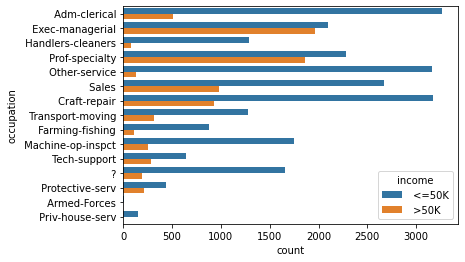

In [83]:
sns.countplot(y='occupation', hue='income', data=adult_data_train)

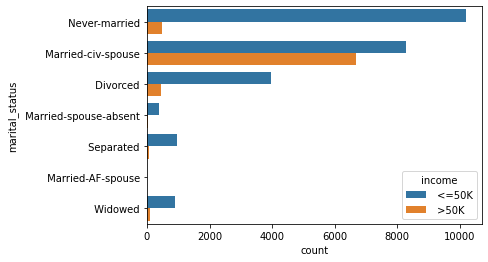

In [88]:
sns.countplot(y='marital_status', hue='income', data=adult_data_train)

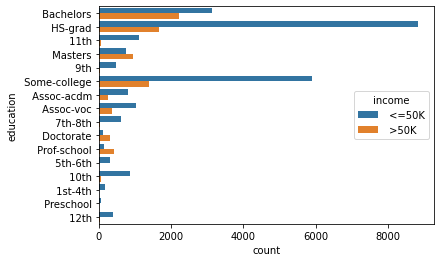

In [89]:
sns.countplot(y='education', hue='income', data=adult_data_train)

# Preprocessing the data

Handle the missing values

In [18]:
#finding out if there are missing values:
adult_data_train.isnull().values.sum()              #total number of missing values

0

The missing values (in the form of "?") occurs in the column "workclass" and "occupation", both containing categorical data. So "?" will be considered as another category. And even if we replace the "?" with some other data, that wont be justified. One way is to drop the rows with the "?" categorical values.

Encoding :

In [19]:
#separating the columns that needs to be encoded
to_be_encoded_train = adult_data_train.select_dtypes(include=['object']).copy()
to_be_encoded_train.head()

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,income
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K


In [22]:
#separating the columns that needs to be encoded
to_be_encoded_test = adult_data_test.select_dtypes(include=['object']).copy()
to_be_encoded_test.head()

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,income
0,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,United-States,<=50K.
1,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,United-States,<=50K.
2,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,United-States,>50K.
3,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,United-States,>50K.
4,?,Some-college,Never-married,?,Own-child,White,Female,United-States,<=50K.


In [0]:
#Ecoding the categorical data
label_encoder=LabelEncoder()

In [0]:
train_data_encoded=to_be_encoded_train.apply(label_encoder.fit_transform)
test_data_encoded=to_be_encoded_test.apply(label_encoder.fit_transform)

In [25]:
train_data_encoded.head()

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,income
0,7,9,4,1,1,4,1,39,0
1,6,9,2,4,0,4,1,39,0
2,4,11,0,6,1,4,1,39,0
3,4,1,2,6,0,2,1,39,0
4,4,9,2,10,5,2,0,5,0


In [26]:
test_data_encoded.head()

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,income
0,4,1,4,7,3,2,1,38,0
1,4,11,2,5,0,4,1,38,0
2,2,7,2,11,0,4,1,38,1
3,4,15,2,7,0,2,1,38,1
4,0,15,4,0,3,4,0,38,0


Standardize scale to prep for KNN Algo

In [0]:
#separating the columns that needs to be standardized
to_be_standardized_train=adult_data_train[['fnlwgt','capital_gain','capital_loss']].copy()
to_be_standardized_test=adult_data_test[['fnlwgt','capital_gain','capital_loss']].copy()

In [0]:
scaler=StandardScaler()

In [0]:
scaler.fit(to_be_standardized_train)
standardized_train=scaler.transform(to_be_standardized_train)

In [0]:
scaler.fit(to_be_standardized_test)
standardized_test=scaler.transform(to_be_standardized_test)

In [0]:
stand_train=pd.DataFrame(standardized_train,columns=['fnlwgt','capital_gain','capital_loss'])
stand_test=pd.DataFrame(standardized_test,columns=['fnlwgt','capital_gain','capital_loss'])

In [41]:
stand_train.head()

,fnlwgt,capital_gain,capital_loss
0,-1.063611,0.148453,-0.21666
1,-1.008707,-0.145920,-0.21666
2,0.245079,-0.145920,-0.21666
3,0.425801,-0.145920,-0.21666
4,1.408176,-0.145920,-0.21666


In [42]:
stand_test.head()

,fnlwgt,capital_gain,capital_loss
0,0.353474,-0.142662,-0.218062
1,-0.942391,-0.142662,-0.218062
2,1.395450,-0.142662,-0.218062
3,-0.275397,0.871091,-0.218062
4,-0.812954,-0.142662,-0.218062


Forming the final dataframes to be fed for training and testing:

In [0]:
X_train=pd.concat([adult_data_train[['age','education_num','hours_per_week']].copy(),stand_train,train_data_encoded.drop(columns='income')],axis=1)
Y_train=train_data_encoded['income']

In [0]:
X_test=pd.concat([adult_data_test[['age','education_num','hours_per_week']].copy(),stand_test,test_data_encoded.drop(columns='income')],axis=1)
Y_test=test_data_encoded['income']

Split into training and test data sets:

Since different datasets are already available for testing and training, train_test_split is not required. 

create and train the model

# The KNN Model

In [0]:
# Find the optimum value of k
k_range=range(1,20)
scores={}
scores_list=[]

for k in k_range:
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,Y_train)
    y_pred=knn.predict(X_test)
    sc=metrics.accuracy_score(Y_test,y_pred)
    scores[k]=sc
    scores_list.append(sc)

Plot error rate

Text(0, 0.5, 'Error Rate')

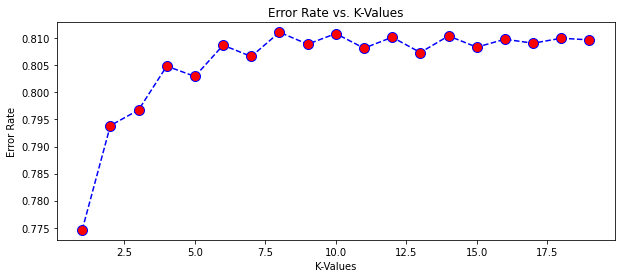

In [70]:
error_rate=[]
for k in k_range:
  error_rate.append(scores[k])

plt.figure(figsize=(10,4))
plt.plot(range(1,20), error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K-Values')
plt.xlabel('K-Values')
plt.ylabel('Error Rate')

Adjust K value per error rate evaluations

In [58]:
#finding the value of k for highest accuracy
k_optimum=max(scores,key=scores.get)
print("value of K: ",k_optimum)
print("Highest accuracy: ",scores[k_optimum])

value of K:  8
Highest accuracy:  0.8111295374976967


Evaluate alternative k values for better prediction

In [59]:
#Train the knn model with optimum value of k
knn=KNeighborsClassifier(n_neighbors=k_optimum)
knn.fit(X_train,Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                     weights='uniform')

In [0]:
#predict the value for the test sets
y_pred=knn.predict(X_test)

In [64]:
#Classification report
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88     12435
           1       0.64      0.45      0.53      3846

    accuracy                           0.81     16281
   macro avg       0.74      0.69      0.70     16281
weighted avg       0.80      0.81      0.80     16281



In [67]:
#Confusion matrix
# Print out confusion matrix
cmat = confusion_matrix(Y_test, y_pred)

print('TP - True Negative {}'.format(cmat[0,0]))
print('FP - False Positive {}'.format(cmat[0,1]))
print('FN - False Negative {}'.format(cmat[1,0]))
print('TP - True Positive {}'.format(cmat[1,1]))
print('Accuracy Rate: {}'.format(np.divide(np.sum([cmat[0,0],cmat[1,1]]),np.sum(cmat))))
print('Misclassification Rate: {}'.format(np.divide(np.sum([cmat[0,1],cmat[1,0]]),np.sum(cmat))))

TP - True Negative 11490
FP - False Positive 945
FN - False Negative 2130
TP - True Positive 1716
Accuracy Rate: 0.8111295374976967
Misclassification Rate: 0.1888704625023033
